# Predicting Player Activity Using Experience, Age, and Gender
### DSCI 100 Group Report

## Introduction

## Methods & Results

Our analysis consisted of four main stages:

1. **Data cleaning and wrangling**  
2. **Exploratory data analysis**  
3. **Model building and hyperparameter tuning**  
4. **Evaluation of model performance**

Each stage is described below and accompanied by relevant code and visualizations.


In [18]:
library(tidyverse)
library(tidymodels)

In [22]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")
head(sessions)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


---
### Data Wrangling

In [26]:
player_data <- players |>
  rowwise() |>
  mutate(
      active = {
      this_email <- hashedEmail
      count_sessions <- nrow(filter(sessions, hashedEmail == this_email))
      if (count_sessions > 0) "Active" else "Inactive"}) |>
  ungroup() |>
  mutate(active = factor(active), gender = factor(gender), experience = factor(experience))

head(player_data)

experience,subscribe,hashedEmail,played_hours,name,gender,Age,active
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,Active
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,Active
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,Active
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,Active
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,Active
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,Inactive


In [27]:
player_data_2 <- player_data |>
    select(-subscribe, -name, -played_hours,-hashedEmail)
head(player_data_2)
dim(player_data_2)

experience,gender,Age,active
<fct>,<fct>,<dbl>,<fct>
Pro,Male,9,Active
Veteran,Male,17,Active
Veteran,Male,17,Active
Amateur,Female,21,Active
Regular,Male,21,Active
Amateur,Female,17,Inactive


[1] 196   4

We first loaded the players and sessions datasets and merged them using the hashed email identifier. We then created an `active` variable, defined as `"Active"` if the player appeared in the sessions table at least once, and `"Inactive"` otherwise.

Experience level, gender, and activity status were converted to factors. We selected only the variables required for modeling—experience, gender, age, and activity—ensuring the dataset was clean and ready for analysis.

The final dataset contained **196 players**, each represented by a unique demographic and experience profile.


In [32]:
summary <- player_data_2 |>
    summarize(age_mean=mean(Age,na.rm=TRUE), age_min=min(Age,na.rm=TRUE), age_max=max(Age,na.rm=TRUE))
summary

age_mean,age_min,age_max
<dbl>,<dbl>,<dbl>
21.13918,9,58


## Exploratory Data Analysis

To understand the structure of the dataset and identify potential relationships, we performed a series of exploratory analyses.

Summary statistics revealed that player ages ranged from *9 to 58*, with an average of approximately *21.1* years. Although the dataset spans multiple experience levels, the distribution of ages across experience groups appears overlapping, suggesting age may not be a strong predictor on its own.

### Visualization (Figures)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


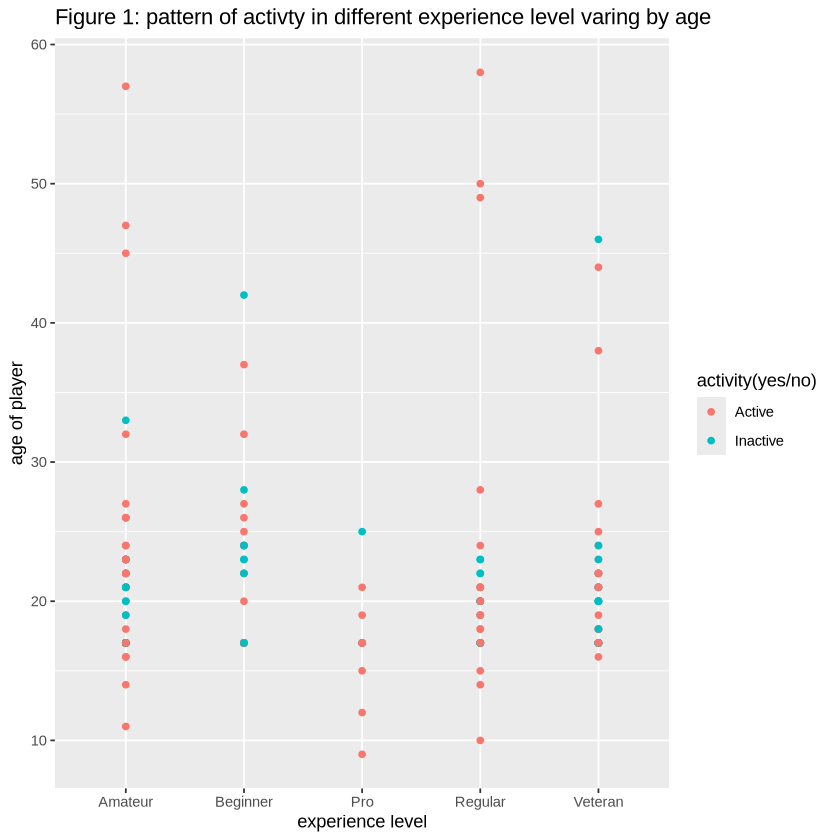

In [29]:
plot_1 <- player_data_2 |>
    ggplot(aes(x=experience, y=Age, color=active))+
    geom_point()+
    labs(x="experience level", y="age of player", color="activity(yes/no)")+
    ggtitle("Figure 1: pattern of activty in different experience level varing by age")
plot_1

Figure 1 shows how experience, age, and activity relate to each other. Active and inactive players appear at every experience level, and there isn’t a clear pattern where certain ages are more active than others. This suggests that age by itself doesn’t do a good job of predicting activity, so we need to consider multiple factors together.


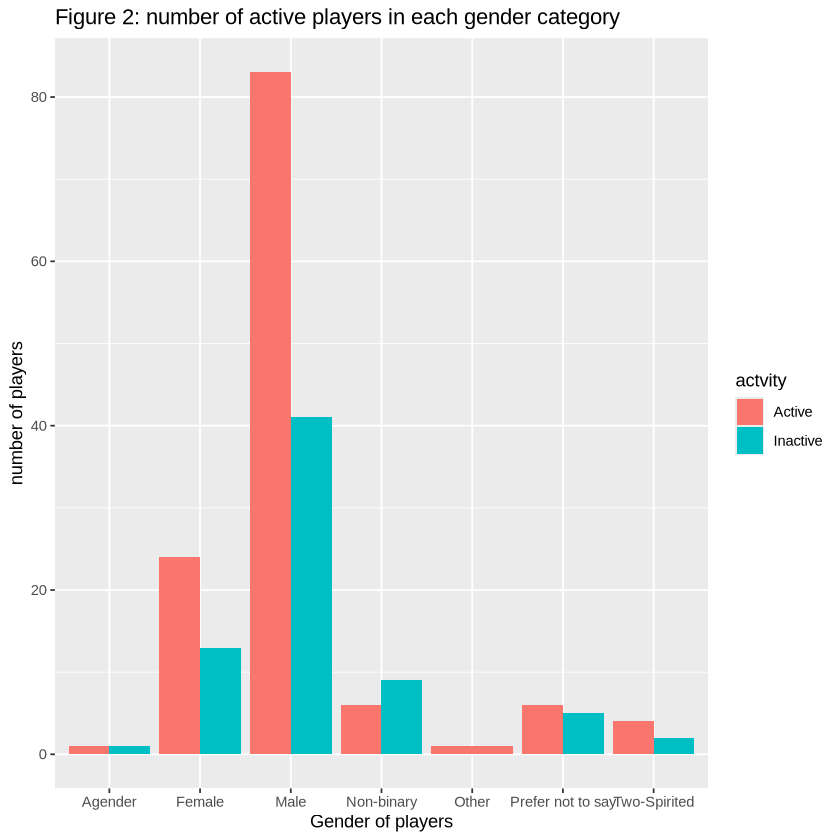

In [42]:
plot_2<- player_data_2 |>
    ggplot(aes(x=gender, fill=active))+
    geom_bar(position = "dodge") + 
    labs(x="Gender of players", y="number of players", fill="actvity") +
    ggtitle("Figure 2: number of active players in each gender category")
plot_2

Figure 2 illustrates the distribution of Active and Inactive players across genders. Although male players form the largest group, the proportion of Active vs. Inactive players appears relatively similar for all genders.

This suggests that **gender is unlikely to be a dominant predictor** of activity but may still contribute when combined with other variables.


### Analysing using Classification

## Classification Analysis

To see whether experience level, gender, and age can help predict whether a player is active or not, we used a **K-nearest neighbours (K-NN)** classification model.

### Train/Test Split
We split the data into:
- 75% for training  
- 25% for testing  

The split was stratified so the ratio of Active/Inactive players stayed balanced in both sets.

### Preprocessing
Before training the model, we:
- turned the categorical variables (experience and gender) into dummy variables  
- normalized the age variable  
- set up K-NN with `neighbors = tune()` so we could try different k-values  

### Hyperparameter Tuning
We tested odd values of k from 1 to 27 using 5-fold cross-validation, and used accuracy to choose the best performing k.


In [9]:
set.seed(1)
data_split <- initial_split(player_data_2, prop = 0.75, strata=active)
training_data <- training(data_split)
testing_data <- testing(data_split)

In [10]:
recipe <- recipe(active ~experience+gender+Age, data=training_data)
knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("classification")
vfold <- vfold_cv(training_data, v=5, strata=active) 
k_vals <- tibble(neighbors=seq(from=1, to=10, by=1))
knn_metric <- workflow()|>
    add_recipe(recipe)|>
    add_model(knn_tune)|>
    tune_grid(resample=vfold, grid=k_vals)|>
    collect_metrics()
accuracy <- knn_metric |>
    filter(.metric == "accuracy")
accuracy


→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 27 rows.
               ✖ Assigned data has 28 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 28 to size 27.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5698413,3,0.04126984,Preprocessor1_Model01
2,accuracy,binary,0.5111111,3,0.04843221,Preprocessor1_Model02
3,accuracy,binary,0.5571429,3,0.01198386,Preprocessor1_Model03
4,accuracy,binary,0.5349206,3,0.02063492,Preprocessor1_Model04
5,accuracy,binary,0.5904762,3,0.03965078,Preprocessor1_Model05
6,accuracy,binary,0.6015873,3,0.03256871,Preprocessor1_Model06
7,accuracy,binary,0.5333333,3,0.01924501,Preprocessor1_Model07
8,accuracy,binary,0.5325397,3,0.03412698,Preprocessor1_Model08
9,accuracy,binary,0.5444444,3,0.02222222,Preprocessor1_Model09


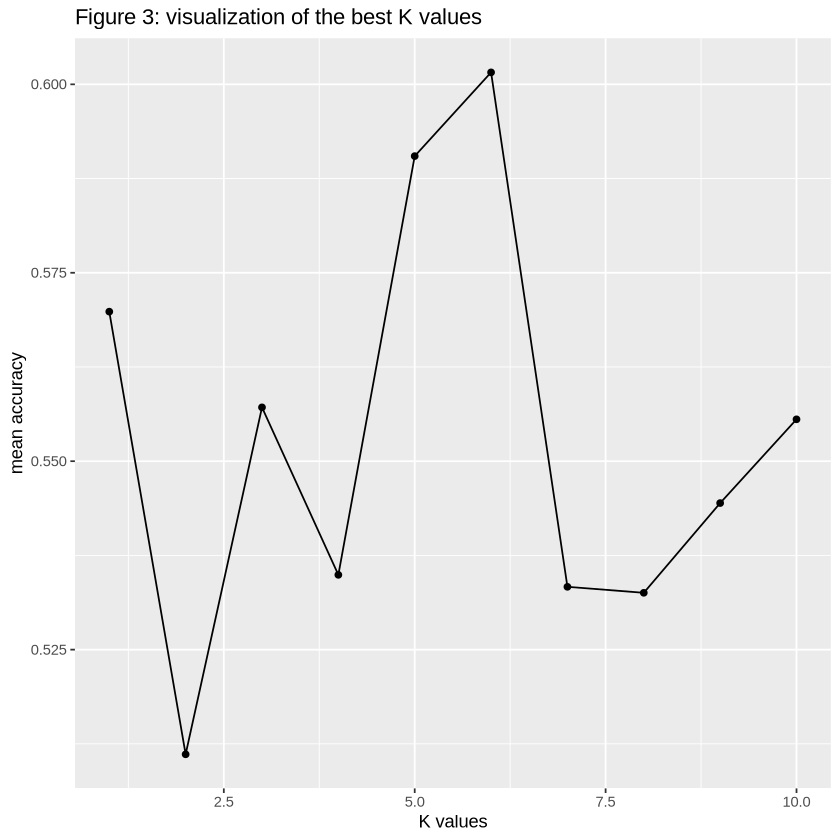

In [11]:
accuracy_plot <- accuracy |>
    ggplot(aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    xlab("K values")+
    ylab("mean accuracy")+
    ggtitle("Figure 3: visualization of the best K values")
accuracy_plot

Figure 3 shows how accuracy changes as we adjust the number of neighbours. The model performs best around k = 6, suggesting that a moderate neighbourhood size works well for this dataset. This tuning step helps us avoid choosing a model that is too sensitive to noise (small k) or too generalized (large k).


In [12]:
knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=6)|>
    set_engine("kknn")|>
    set_mode("classification")
knn_fit <- workflow()|>
    add_recipe(recipe)|>
    add_model(knn_spec)|>
    fit(data=training_data)
prediction <- predict(knn_fit, testing_data)|>
    bind_cols(testing_data)
head(prediction)

.pred_class,experience,gender,Age,active
<fct>,<fct>,<fct>,<dbl>,<fct>
Active,Veteran,Male,17,Active
Active,Amateur,Female,21,Active
Inactive,Regular,Male,21,Active
Inactive,Veteran,Female,23,Active
Active,Pro,Male,17,Inactive
Active,Veteran,Non-binary,17,Inactive


In [13]:
confusion <- prediction |> 
conf_mat(truth =active, estimate = .pred_class)
confusion #do we want to keep this?

          Truth
Prediction Active Inactive
  Active       26       15
  Inactive      6        3

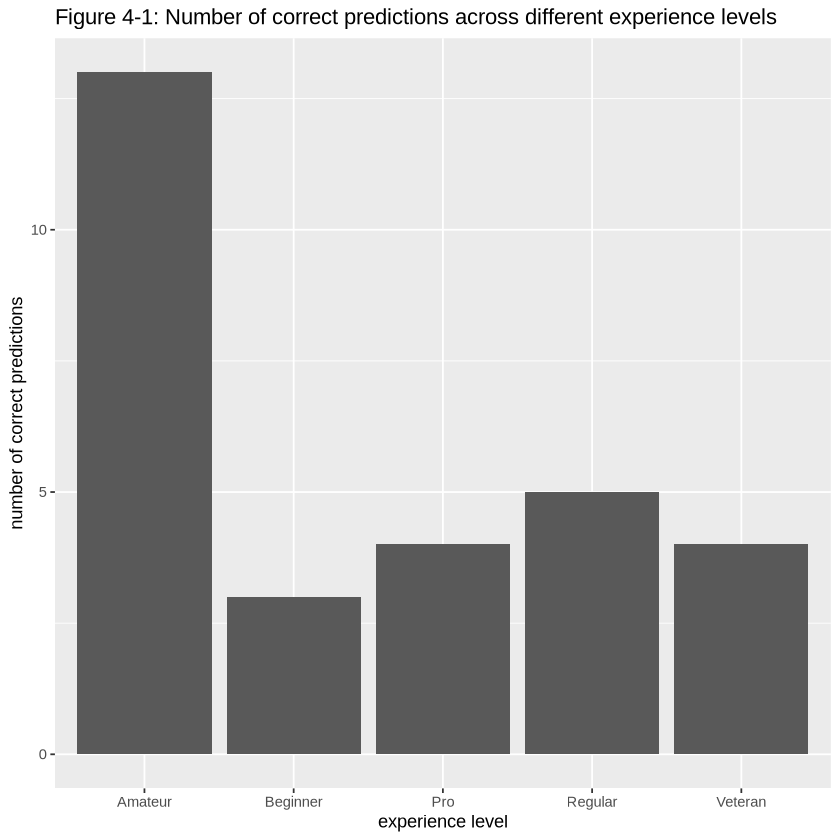

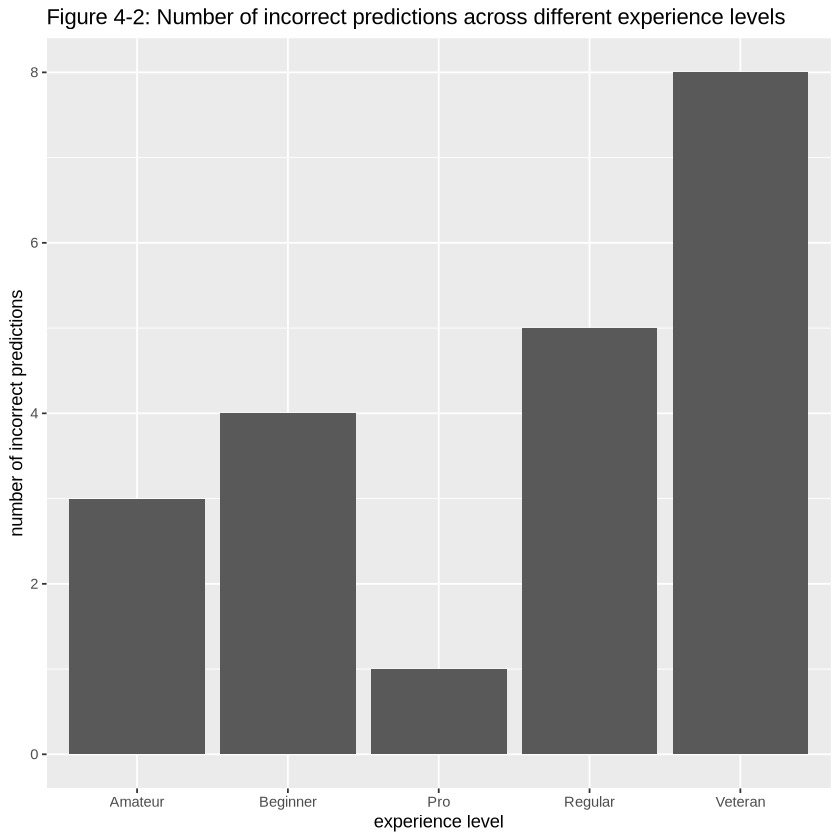

In [14]:
result_correct_plot <- prediction |>
    filter(.pred_class == active) |>
    ggplot(aes(x=experience))+
    geom_bar()+
    xlab("experience level")+
    ylab("number of correct predictions")+
    ggtitle("Figure 4-1: Number of correct predictions across different experience levels")
result_incorrect_plot <- prediction |>
    filter(.pred_class != active)|>
    ggplot(aes(x=experience))+
    geom_bar()+
    xlab("experience level")+
    ylab("number of incorrect predictions")+
    ggtitle("Figure 4-2: Number of incorrect predictions across different experience levels")
result_correct_plot 
result_incorrect_plot #are these plots useful?

In [15]:
result_accuracy <- prediction |>
    metrics(truth=active, estimate=.pred_class)|>
    filter(.metric=="accuracy")
pull(result_accuracy, .estimate)

[1] 0.58

In [16]:
precision <- prediction |> 
precision(truth = active, estimate = .pred_class, event_level = "first") 
pull(precision, .estimate)

[1] 0.6341463

In [17]:
recall <- prediction |> recall(truth = active, estimate = .pred_class, event_level = "first")
pull(recall, .estimate)

[1] 0.8125